# Anomaly Detection with Autoencoders


We will train an autoencoder to detect anomalies on the ECG5000 dataset. In this dataset, there are 5000 Electrocardiograms (ECG). Each one of them has 140 data points.

We will use a simplified version of the dataset, where each example has been labeled either `0` (abnormal rhythm), or `1` (normal rhythm). Our goal is to identify abnormal rhythms. Since the dataset has labels, this is a supervised machine learning problem.

**How will we use an autoencoder to detect anomalies?**
  
  We will first train an autoencoder on only the 'normal' rhythms. So, the autoencoder would taken the image, compress it and them reconstruct it as accurately as possible. Once, the autoencoder has been trained, you use it to reconstruct all the data, including the normal and abnormal rhythms. Since, the model was trained on normal data, it should be able to reconstruct normal rhythms with lower error compared to abnormal rhythms.

  Once we have calculated the reconstruction error for each rhythm, we can classify them as either normal or abnormal based on whether their error exceeds the threshold.





In [84]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras import Model

In [85]:
# Load ECG Data
dataframe = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## EDA & Data pre-processing

In [86]:
# remove last column with labels
labels = raw_data[:, -1]

# Keep all the other data points
data = raw_data[:, 0:-1]

# splitting the data into training and etsting samples
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)

In [87]:
# Normalize the data
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data -min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

`tf.reduce_min` finds the minimum values in the entire dataset. Similarly, `tf.reduce_max` finds the maximum values in the entire dataset.



In [88]:
# Converting labels to boolean
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Filter out the normal rhythms
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

# Filtering out the abnormal rhythms
abnormal_train_data = train_data[~train_labels]
abnormal_test_data = test_data[~test_labels]

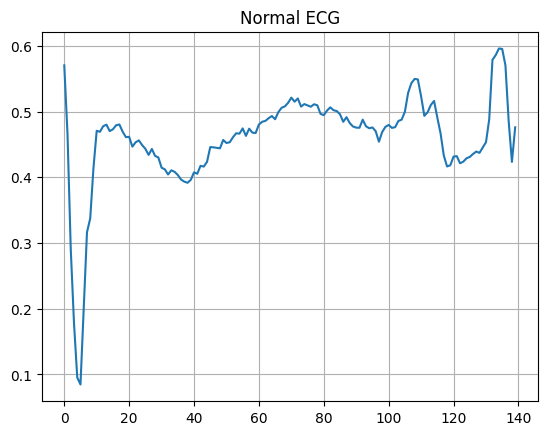

In [89]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('Normal ECG')
plt.show()

`np.arange(140)` generates an array of integers from 0 to 139. This is used for plotting on the x-axis values.

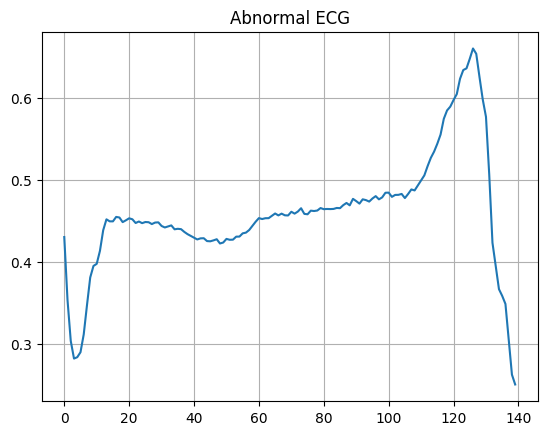

In [90]:
plt.grid()
plt.plot(np.arange(140), abnormal_train_data[0])
plt.title('Abnormal ECG')
plt.show()

### Model Definition

In [91]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    # encoder part
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dropout(.2),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    # decoder part
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dropout(.2),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  # model's activation function
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Autoencoder model instantiation
autoencoder = AnomalyDetector()


In [92]:
# model hyperparameters
autoencoder.compile(optimizer='adam', loss='mae')

In [93]:
# training hyperparameters
# observe that we used the same training data as input and target; the same for the testing data
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 55ms/step - loss: 0.0584 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0568 - val_loss: 0.0526
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0554 - val_loss: 0.0513
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0536 - val_loss: 0.0499
Epoch 5/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0511 - val_loss: 0.0481
Epoch 6/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0480 - val_loss: 0.0467
Epoch 7/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0449 - val_loss: 0.0452
Epoch 8/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0419 - val_loss: 0.0433
Epoch 9/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0390 - val_loss: 0.0420
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0365 - val_loss: 0.0408
Epoch 11/20
5/5 [============

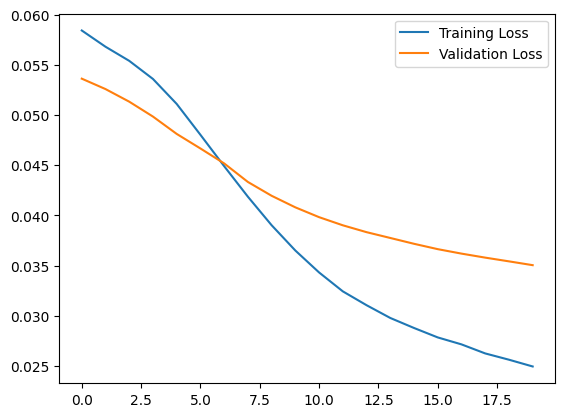

In [94]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Classification

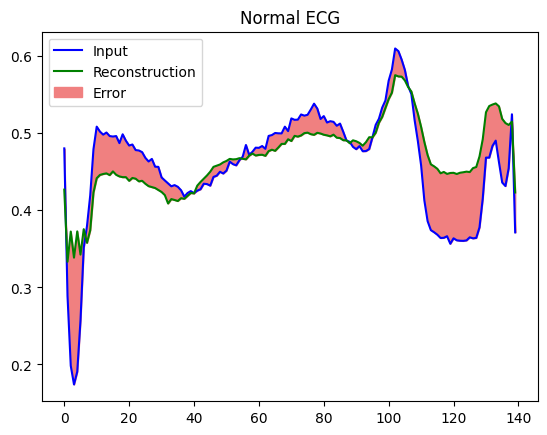

In [95]:
# encoding phase - normal ECG
encoded_data = autoencoder.encoder(normal_test_data).numpy()
# decoding phase
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'g')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title('Normal ECG')
plt.show()

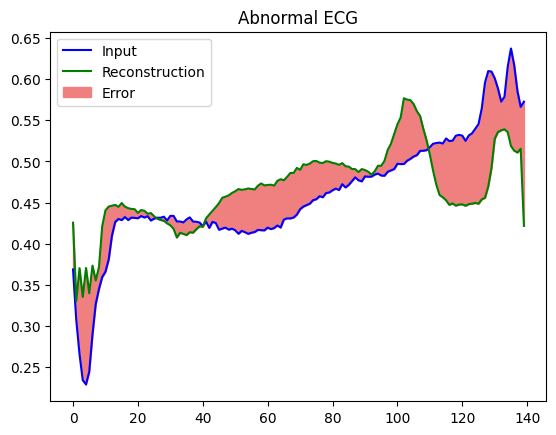

In [96]:
# encoding phase - abnormal ECG
encoded_data = autoencoder.encoder(abnormal_test_data).numpy()
# decoding phase
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(abnormal_test_data[0], 'b')
plt.plot(decoded_data[0], 'g')
plt.fill_between(np.arange(140), decoded_data[0], abnormal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title('Abnormal ECG')
plt.show()

## Anomaly Detection

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. We will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.



74/74 [==============================] - 0s 2ms/step


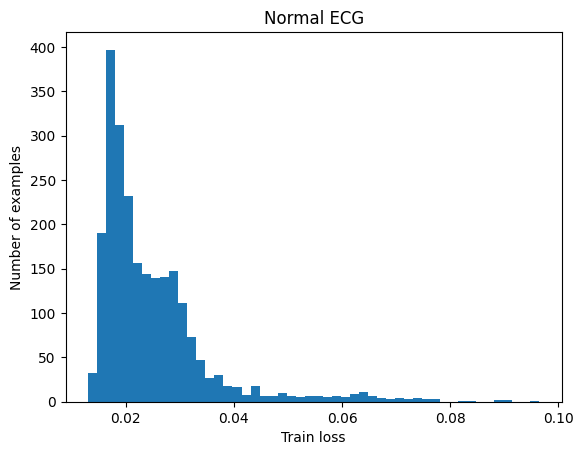

In [102]:
# prediction phase - normal ECG
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.title('Normal ECG')
plt.xlabel("Train loss")
plt.ylabel("Number of examples")
plt.show()

In [98]:
# hyperparameter for classification
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.035592787


14/14 [==============================] - 0s 2ms/step


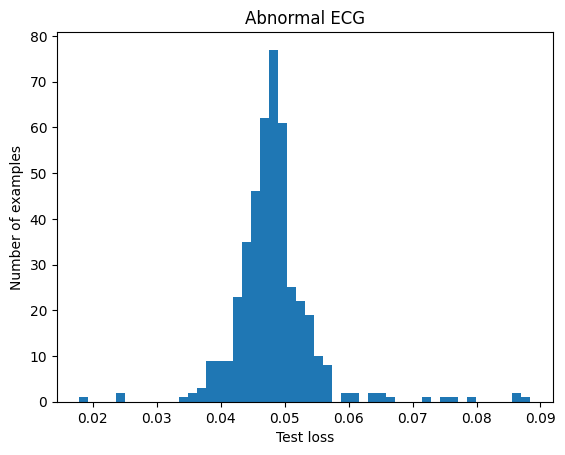

In [103]:
# prediction phase - abnormal ECG
reconstructions = autoencoder.predict(abnormal_test_data)
test_loss = tf.keras.losses.mae(reconstructions, abnormal_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.title('Abnormal ECG')
plt.xlabel("Test loss")
plt.ylabel("Number of examples")
plt.show()

In [100]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print(" Accuracy: {}".format(accuracy_score(labels, predictions)))
  print("Precision: {}".format(precision_score(labels, predictions)))
  print("   Recall: {}".format(recall_score(labels, predictions)))

In [101]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

 Accuracy: 0.942
Precision: 0.9883268482490273
   Recall: 0.9071428571428571
